In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os

In [2]:
!wget http://www.kasprowski.pl/datasets/adversarial/signs_model.h5

--2022-01-22 00:13:28--  http://www.kasprowski.pl/datasets/adversarial/signs_model.h5
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50732024 (48M) [text/plain]
Saving to: ‘signs_model.h5’

signs_model.h5      100%[===================>]  48.38M  11.8MB/s    in 4.8s    

2022-01-22 00:13:34 (10.1 MB/s) - ‘signs_model.h5’ saved [50732024/50732024]



In [3]:
!wget http://www.kasprowski.pl/datasets/adversarial/signs_labels.csv

--2022-01-22 00:13:57--  http://www.kasprowski.pl/datasets/adversarial/signs_labels.csv
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [text/csv]
Saving to: ‘signs_labels.csv’

signs_labels.csv    100%[===================>]   1.02K  --.-KB/s    in 0s      

2022-01-22 00:13:57 (105 MB/s) - ‘signs_labels.csv’ saved [1041/1041]



In [4]:
!wget http://www.kasprowski.pl/datasets/adversarial/stop.jpg   


--2022-01-22 00:14:10--  http://www.kasprowski.pl/datasets/adversarial/stop.jpg
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86276 (84K) [image/jpeg]
Saving to: ‘stop.jpg’

stop.jpg            100%[===================>]  84.25K   239KB/s    in 0.4s    

2022-01-22 00:14:10 (239 KB/s) - ‘stop.jpg’ saved [86276/86276]



In [9]:
model = tf.keras.models.load_model("signs_model.h5")

In [10]:
image = cv2.imread("stop.jpg")


In [11]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [12]:
image = cv2.resize(image, (64,64))


In [14]:
import pandas as pd
classes = pd.read_csv('signs_labels.csv')
for i in range(20):
    print(f'Label {i}: {classes.loc[i][1]}')

Label 0: Speed limit (20km/h)
Label 1: Speed limit (30km/h)
Label 2: Speed limit (50km/h)
Label 3: Speed limit (60km/h)
Label 4: Speed limit (70km/h)
Label 5: Speed limit (80km/h)
Label 6: End of speed limit (80km/h)
Label 7: Speed limit (100km/h)
Label 8: Speed limit (120km/h)
Label 9: No passing
Label 10: No passing for vehicles over 3.5 metric tons
Label 11: Right-of-way at the next intersection
Label 12: Priority road
Label 13: Yield
Label 14: Stop
Label 15: No vehicles
Label 16: Vehicles over 3.5 metric tons prohibited
Label 17: No entry
Label 18: General caution
Label 19: Dangerous curve to the left


Image classified as class 14, Stop with probalility 0.9609633088111877


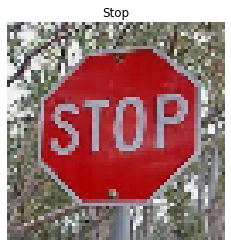

In [15]:
image2 = np.expand_dims(image, axis=0)
# predict
pred = model.predict(image2)
max = pred[0].argmax()
plt.imshow(image)
plt.title(classes.loc[max][1])
plt.axis("off")
print(f'Image classified as class {max}, {classes.loc[max][1]} with probalility {pred[0][max]}')

In [16]:
real_class = 14
real_label = "stop"
real_pred = pred[0][max]

In [17]:
baseImage = tf.constant(image2, dtype=tf.float32)
print("Image loaded")

Image loaded


In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [19]:
optimizer = Adam(learning_rate=0.1)
lossFunct = SparseCategoricalCrossentropy()


In [20]:
def do_step(image,delta,real_class, target_class):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        adversary = tf.keras.applications.resnet50.preprocess_input(baseImage + delta)
        predictions = model(adversary, training=False)

        originalLoss = lossFunct(tf.convert_to_tensor([real_class]),predictions)
        targetLoss = lossFunct(tf.convert_to_tensor([target_class]),predictions)
        loss = targetLoss - originalLoss  # goal: minimize error to targetLoss and maximize error to originalLoss

    gradients = tape.gradient(loss, delta)
    optimizer.apply_gradients([(gradients, delta)])
    delta.assign_add(delta)
    
    optimizer.apply_gradients([(gradients, delta)])
    clipped_delta = tf.clip_by_value(delta, clip_value_min=-0.01, clip_value_max=0.01)
    delta.assign_add(clipped_delta)
    
    return delta,loss

In [21]:
image_name = "stop"

def show_step(delta,loss):  

    adverImage = (baseImage + delta).numpy().squeeze()
    adverImage = np.clip(adverImage, 0, 255).astype("uint8")
    adverImage = np.expand_dims(adverImage, axis=0)
    predicted  = model.predict(adverImage)
    predicted_class = predicted.argmax(axis=-1)[0]
    predicted_label = classes.loc[predicted_class][1]
    predicted_pred  = predicted[0][predicted_class]

    fig=plt.figure(figsize=(12,8))

    ax = plt.subplot(1, 3, 1)
    plt.title(f"Original {real_label}:{100*real_pred:.2f}%")
    plt.imshow(image.squeeze())
    plt.axis("off")  

    ax = plt.subplot(1, 3, 2)
    plt.title("Delta")
    plt.imshow(np.clip((delta.numpy().squeeze()*256).astype("uint8"), 0, 255))
    plt.axis("off")  

    ax = plt.subplot(1, 3, 3)
    plt.title(f"Adversary {predicted_label}:{100*predicted_pred:.2f}%")
    plt.imshow(adverImage.squeeze())
    plt.axis("off")  

    plt.show() 
    cv2.imwrite(f"outdir/{image_name}_{step:02d}.jpg", cv2.cvtColor(adverImage.squeeze(), cv2.COLOR_RGB2BGR))

In [22]:
classes.loc[12][1]


'Priority road'

In [23]:
classes.loc[12][0]

12

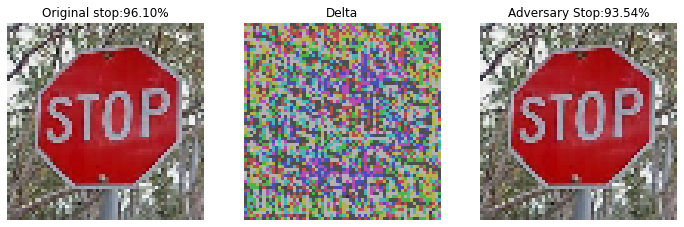

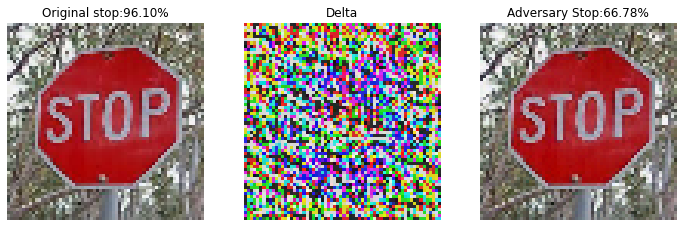

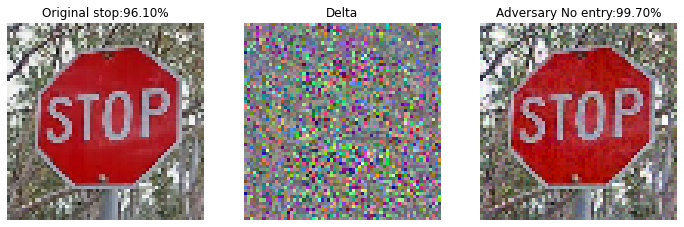

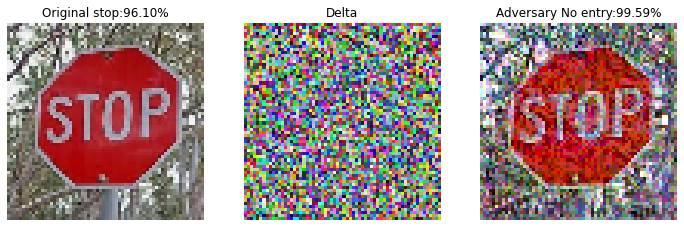

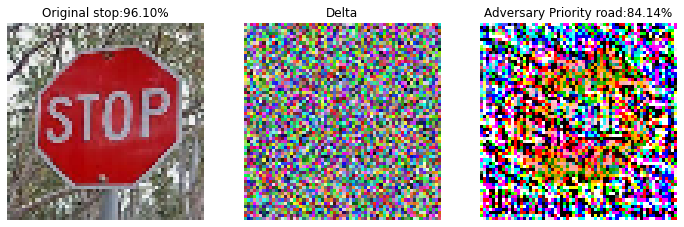

Done


In [24]:
steps = 10
real_class = classes.loc[12][0]

target_class = 12 # code of "Priority road" class

delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)
for step in range(0, steps):
    delta,loss = do_step(baseImage, delta, 14, target_class)
    if step % 2==0:
        show_step(delta,loss)
print("Done")